In [8]:
import os
import sys
import json
import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

In [2]:
# 设置训练参数
epochs = 10
batch_size = 32
save_path = "./AlexNet.pth"


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device".format(device))

using cuda:0 device


In [3]:
# 加载数据集
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(), # 随机水平翻转，提高泛化能力
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
}

data_root = os.path.abspath("./data_set")
image_path = os.path.join(data_root, "flower_data")
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"), transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

# nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 4])  # number of workers
nw = 0
print("using {} dataloader workers every process".format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"), transform=data_transform["val"])

val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 0 dataloader workers every process
using 3306 images for training, 364 images for validation.


daisy daisy daisy daisy


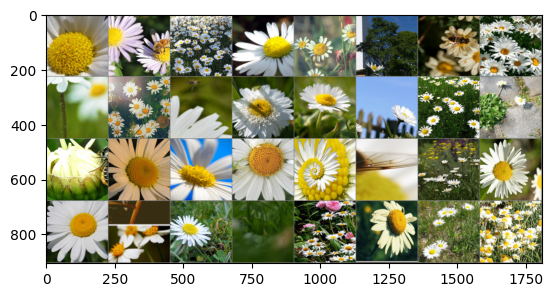

In [4]:
# 可视化数据集
test_data_iter = iter(validate_loader)
test_image, test_label = test_data_iter.next()

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print(' '.join('%5s' % cla_dict[test_label[j].item()] for j in range(4)))
imshow(utils.make_grid(test_image))


In [5]:
# 构建AlexNet模型
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),  # input[3,224,224] output[48,55,55]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),   # output[48,27,27]
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),   # output[128,13,13]
            nn.Conv2d(128, 192, kernel_size=3, padding=1), # output[192,13,13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1), # output[128,13,13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),   # output[128,6,6]
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )

    # 定义前向传播
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [6]:
# 训练代码
net = AlexNet(5)

net.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)

best_acc = 0.0

train_step = len(train_loader)
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss.item())

    net.eval()
    acc = 0.0
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, 1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

    val_accurate = acc / val_num
    print('epoch %d train loss: %.3f  val accuracy: %.3f' % (epoch + 1, running_loss / train_step, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finish Training')


100%|██████████| 12/12 [00:00<00:00, 16.27it/s]
epoch 1 train loss: 1.406  val accuracy: 0.451
100%|██████████| 12/12 [00:00<00:00, 14.86it/s]
epoch 2 train loss: 1.177  val accuracy: 0.459
100%|██████████| 12/12 [00:00<00:00, 15.96it/s]
epoch 3 train loss: 1.107  val accuracy: 0.626
100%|██████████| 12/12 [00:00<00:00, 16.44it/s]
epoch 4 train loss: 1.009  val accuracy: 0.624
100%|██████████| 12/12 [00:00<00:00, 15.67it/s]
epoch 5 train loss: 0.959  val accuracy: 0.626
100%|██████████| 12/12 [00:00<00:00, 15.78it/s]
epoch 6 train loss: 0.929  val accuracy: 0.651
100%|██████████| 12/12 [00:00<00:00, 15.84it/s]
epoch 7 train loss: 0.875  val accuracy: 0.701
100%|██████████| 12/12 [00:00<00:00, 15.22it/s]
epoch 8 train loss: 0.862  val accuracy: 0.676
100%|██████████| 12/12 [00:00<00:00, 14.57it/s]
epoch 9 train loss: 0.847  val accuracy: 0.698
100%|██████████| 12/12 [00:00<00:00, 15.21it/s]
epoch 10 train loss: 0.781  val accuracy: 0.673
Finish Training


class: daisy      prob: 6.15e-05
class: dandelion  prob: 2.94e-05
class: roses      prob: 0.0483
class: sunflowers prob: 0.0022
class: tulips     prob: 0.949


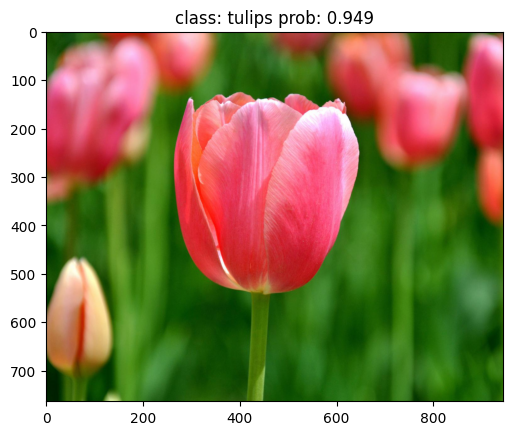

In [10]:
# 测试代码

img_path = "./tulip.png"
assert os.path.exists(img_path), "file: '{}' does not exist.".format(img_path)
img = Image.open(img_path)

plt.imshow(img)

img = data_transform["val"](img)
img = torch.unsqueeze(img, 0)

json_path = "./class_indices.json"
assert os.path.exists(json_path), "file: '{}' does not exist.".format(json_path)

with open(json_path, "r") as json_file:
    class_indict = json.load(json_file)

model = AlexNet(num_classes=5)
model.to(device)
weight_path = "./AlexNet.pth"
assert os.path.exists(weight_path), "file: '{}' does not exist.".format(weight_path)
model.load_state_dict(torch.load(weight_path))

model.eval()
with torch.no_grad():
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {} prob: {:.3}".format(class_indict[str(predict_cla)], predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10} prob: {:.3}".format(class_indict[str(i)], predict[i].numpy()))

plt.show()
